In [27]:
from datetime import datetime
import os
import warnings

import heliopy.data.omni as omni
from keras import backend as K
from matplotlib import pyplot as plt
import optuna
from optuna import visualization as viz
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import ks_2samp
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras

from typing import *

warnings.filterwarnings("ignore")
plt.style.use("seaborn")

### Data Preparation

In [28]:
START_TIME_CYCLE_21 = datetime(1976, 3, 1)  
START_TIME_CYCLE_22 = datetime(1986, 9, 1)  
START_TIME_CYCLE_23 = datetime(1996, 8, 1)  
START_TIME_CYCLE_24 = datetime(2008, 12, 1)  
START_TIME_CYCLE_25 = datetime(2019, 12, 1)

INPUT_LENGTH = 100
OUTPUT_LENGTH = 24
PERCENTILE = 10
VAR_TO_PREDICT = "BN"

In [29]:
def get_omni_rtn_data(start_time, end_time):
    identifier = 'OMNI_COHO1HR_MERGED_MAG_PLASMA'  # COHO 1HR data
    omni_data = omni._omni(start_time, end_time, identifier=identifier, intervals='yearly', warn_missing_units=False)
    return omni_data

In [30]:
cycle_21 = get_omni_rtn_data(START_TIME_CYCLE_21, START_TIME_CYCLE_22).to_dataframe()
cycle_22 = get_omni_rtn_data(START_TIME_CYCLE_22, START_TIME_CYCLE_23).to_dataframe()
cycle_23 = get_omni_rtn_data(START_TIME_CYCLE_23, START_TIME_CYCLE_24).to_dataframe()
cycle_24 = get_omni_rtn_data(START_TIME_CYCLE_24, START_TIME_CYCLE_25).to_dataframe()

mag_field_strength_21 = np.array(cycle_21[VAR_TO_PREDICT])
mag_field_strength_22 = np.array(cycle_22[VAR_TO_PREDICT])
mag_field_strength_23 = np.array(cycle_23[VAR_TO_PREDICT])
mag_field_strength_24 = np.array(cycle_24[VAR_TO_PREDICT])

In [31]:
def lstm_prepare_1d(mag_field_strength, input_length=INPUT_LENGTH, output_length=OUTPUT_LENGTH):
    inputs = np.array([mag_field_strength[i:i + input_length] 
                       for i in range(len(mag_field_strength) - input_length)])[:, :, np.newaxis]
    outputs = np.array([mag_field_strength[i + input_length:i + input_length + output_length] 
                        for i in range(len(mag_field_strength) - input_length - output_length)])


    nan_check = np.array([mag_field_strength[i:i + input_length + output_length] 
                          for i in range(len(mag_field_strength) - input_length - output_length)])

    inputs = inputs[np.where([~np.any(np.isnan(i)) for i in nan_check])]
    outputs = outputs[np.where([~np.any(np.isnan(i)) for i in nan_check])]
    

    print("Input shape:", inputs.shape)
    print("Output shape:", outputs.shape)
    print("Any Nans?:", np.any(np.isnan(outputs)) or np.any(np.isnan(inputs)))
    print("")
    return inputs, outputs

### Train/Val/Test

In [32]:
inputs_21, outputs_21 = lstm_prepare_1d(mag_field_strength_21)
inputs_23, outputs_23 = lstm_prepare_1d(mag_field_strength_23)
inputs_val, outputs_val = lstm_prepare_1d(mag_field_strength_22)
inputs_test, outputs_test = lstm_prepare_1d(mag_field_strength_24)

Input shape: (5132, 100, 1)
Output shape: (5132, 24)
Any Nans?: False

Input shape: (105288, 100, 1)
Output shape: (105288, 24)
Any Nans?: False

Input shape: (11376, 100, 1)
Output shape: (11376, 24)
Any Nans?: False

Input shape: (95144, 100, 1)
Output shape: (95144, 24)
Any Nans?: False



In [33]:
inputs_train = np.concatenate([inputs_21, inputs_23])
outputs_train = np.concatenate([outputs_21, outputs_23])

### Subset for AnEn

In [34]:
training_field_strength = np.concatenate([mag_field_strength_21, mag_field_strength_23])
training_field_strength = training_field_strength[training_field_strength == training_field_strength]
solar_storm = np.percentile(training_field_strength, PERCENTILE)

0.46069777217318203 0.46079626671151097


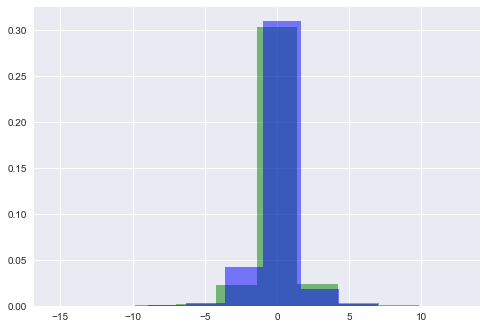

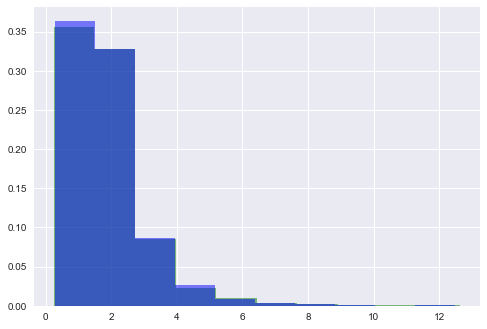

In [35]:
outputs_test_mean = np.mean(outputs_test, axis=1)
outputs_test_std = np.std(outputs_test, axis=1)
outputs_test_binary = np.any(outputs_test <= solar_storm, axis=1).astype(int)

test_set = np.transpose(np.stack((outputs_test_mean, outputs_test_std, outputs_test_binary)))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in split.split(test_set, test_set[:, 2]):
    strat_test_set = test_set[test_index]

print(strat_test_set[:, 2].sum() / len(strat_test_set), test_set[:, 2].sum() / len(test_set))
plt.hist(outputs_test_mean, alpha=0.5, density=True, color="green")
plt.hist(strat_test_set[:, 0], alpha=0.5, density=True, color="blue")
plt.show()
plt.hist(outputs_test_std, alpha=0.5, density=True, color="green")
plt.hist(strat_test_set[:, 1], alpha=0.5, density=True, color="blue")
plt.show()

In [38]:
inputs_strat_test_set = inputs_train[test_index]
outputs_strat_test_set = strat_test_set[:, 2]

### Convert to classification

In [39]:
outputs_train = np.any(outputs_train <= solar_storm, axis=1).astype(int)
outputs_val = np.any(outputs_val <= solar_storm, axis=1).astype(int)
outputs_test = np.any(outputs_test <= solar_storm, axis=1).astype(int)

### Normalise

In [40]:
inputs_train_norm = (inputs_train - np.nanmean(training_field_strength)) / np.nanstd(training_field_strength)
inputs_val_norm = (inputs_val - np.nanmean(training_field_strength)) / np.nanstd(training_field_strength)
inputs_test_norm = (inputs_test - np.nanmean(training_field_strength)) / np.nanstd(training_field_strength)

### Baselines

In [79]:
def print_metrics(y_true, y_pred):
    tp = np.logical_and(y_true == 1, y_pred == 1).sum()
    tn = np.logical_and(y_true == 0, y_pred == 0).sum()
    fp = np.logical_and(y_true == 0, y_pred == 1).sum()
    fn = np.logical_and(y_true == 1, y_pred == 0).sum()
    
    print("Sens:", np.round(100 * tp / (tp + fn), 2))
    print("Spec:", np.round(100 * tn / (tn + fp), 2))
    print("Prec:", np.round(100 * tp / (tp + fp), 2))
    print("NPV:", np.round(100 * tn / (tn + fn), 2))
    
    print("Acc:", np.round(100 * (tn + tp) / len(y_true), 2))
    print("F1:", 100 * np.round(fbeta_score(y_true, y_pred, beta=1), 2))
    print("F2:", 100 * np.round(fbeta_score(y_true, y_pred, beta=2), 2))
    print("\n")

In [76]:
BASELINE_DATAPOINTS = 24

In [80]:
print("ALL O")
for out in [outputs_train, outputs_val, outputs_test]:
    print_metrics(np.zeros_like(out), out)

ALL O
Sens: nan
Spec: 46.19
Prec: 0.0
NPV: 100.0
Acc: 46.19
F1: 0.0
F2: 0.0


Sens: nan
Spec: 52.95
Prec: 0.0
NPV: 100.0
Acc: 52.95
F1: 0.0
F2: 0.0


Sens: nan
Spec: 53.92
Prec: 0.0
NPV: 100.0
Acc: 53.92
F1: 0.0
F2: 0.0




In [81]:
print("ANY 24")
for inp, out in zip([inputs_train, inputs_val, inputs_test],
                    [outputs_train, outputs_val, outputs_test]):
    print_metrics(np.any(inp[:, -BASELINE_DATAPOINTS:] <= solar_storm, axis=1).astype(int)[:, 0], out)

ANY 24
Sens: 64.79
Spec: 58.99
Prec: 64.79
NPV: 58.99
Acc: 62.11
F1: 65.0
F2: 65.0


Sens: 54.12
Spec: 59.23
Prec: 54.07
NPV: 59.28
Acc: 56.83
F1: 54.0
F2: 54.0


Sens: 56.42
Spec: 62.79
Prec: 56.53
NPV: 62.68
Acc: 59.85
F1: 56.00000000000001
F2: 56.00000000000001




In [82]:
print("MEAN 24")
for inp, out in zip([inputs_train, inputs_val, inputs_test],
                    [outputs_train, outputs_val, outputs_test]):
    print_metrics((np.mean(inp[:, -BASELINE_DATAPOINTS:], axis=1) <= solar_storm).astype(int)[:, 0], out)

MEAN 24
Sens: 80.8
Spec: 46.9
Prec: 3.83
NPV: 98.94
Acc: 47.76
F1: 7.000000000000001
F2: 16.0


Sens: 77.4
Spec: 53.43
Prec: 2.56
NPV: 99.34
Acc: 53.81
F1: 5.0
F2: 11.0


Sens: 78.82
Spec: 54.42
Prec: 2.55
NPV: 99.41
Acc: 54.78
F1: 5.0
F2: 11.0




In [83]:
print("LAST")
for inp, out in zip([inputs_train, inputs_val, inputs_test],
                    [outputs_train, outputs_val, outputs_test]):
    print_metrics((np.mean(inp[:, -1:], axis=1) <= solar_storm).astype(int)[:, 0], out)

LAST
Sens: 88.29
Spec: 49.72
Prec: 15.21
NPV: 97.65
Acc: 53.29
F1: 26.0
F2: 45.0


Sens: 81.39
Spec: 55.27
Prec: 10.95
NPV: 97.78
Acc: 56.93
F1: 19.0
F2: 36.0


Sens: 84.52
Spec: 56.8
Prec: 12.79
NPV: 98.0
Acc: 58.74
F1: 22.0
F2: 40.0




In [84]:
print("0.025 QUANT")
for inp, out in zip([inputs_train, inputs_val, inputs_test],
                    [outputs_train, outputs_val, outputs_test]):
    print_metrics((np.quantile(inp[:, -BASELINE_DATAPOINTS:], 0.025, axis=1) <= solar_storm).astype(int)[:, 0], out)

0.025 QUANT
Sens: 66.44
Spec: 56.5
Prec: 55.5
NPV: 67.34
Acc: 60.97
F1: 60.0
F2: 64.0


Sens: 56.32
Spec: 58.14
Prec: 42.94
NPV: 70.42
Acc: 57.49
F1: 49.0
F2: 53.0


Sens: 58.33
Spec: 61.15
Prec: 46.99
NPV: 71.31
Acc: 60.1
F1: 52.0
F2: 56.00000000000001




### LSTM

In [48]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(outputs_train),
                                                 outputs_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [61]:
class AccuracyCallback(tf.keras.callbacks.Callback):

    def __init__(self, data):
        self.data = data

    def on_epoch_end(self, epoch, logs=None):
        x_data, y_data = self.data
        y_pred = np.round(self.model.predict(x_data, verbose=0)[:, 0])

        tp = np.logical_and(y_data == 1, y_pred == 1).sum()
        tn = np.logical_and(y_data == 0, y_pred == 0).sum()
        fp = np.logical_and(y_data == 0, y_pred == 1).sum()
        fn = np.logical_and(y_data == 1, y_pred == 0).sum()
        
        print("TP, TN, FP, FN:", tp, tn, fp, fn)
        print("Sens:", np.round(100 * tp / (tp + fn), 2))
        print("Spec:", np.round(100 * tn / (tn + fp), 2))
        print("Prec:", np.round(100 * tp / (tp + fp), 2))
        print("NPV:", np.round(100 * tn / (tn + fn), 2))
        print("Accuracy:", np.round(100 * (tn + tp) / len(y_data), 2))
        print("")

In [85]:
def f_score(y_true, y_pred, beta=2):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon()) 
    recall = true_positives / (possible_positives + K.epsilon())
    return (1 + beta ** 2) * (precision * recall) / ((precision * beta ** 2) + recall + K.epsilon())

In [87]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(32, name="lstm_initial", input_shape=(None, 1)),
        keras.layers.Dense(1, name="dense_final", activation="sigmoid"),
    ]
)

optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy", f_score])
model.fit(inputs_train_norm[:, -24:], outputs_train, validation_data=(inputs_val_norm[:, -24:], outputs_val),
          batch_size=32, epochs=500, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10, monitor="val_f_score"),
                     AccuracyCallback((inputs_val_norm[:, -24:], outputs_val))],
          class_weight=class_weights)


Epoch 1/500
3451/3451 - 20s - loss: 0.6222 - accuracy: 0.6484 - f_score: 0.6248 - val_loss: 0.6663 - val_accuracy: 0.6079 - val_f_score: 0.3154
TP, TN, FP, FN: 2551 4364 1660 2801
Sens: 47.66
Spec: 72.44
Prec: 60.58
NPV: 60.91
Accuracy: 60.79

Epoch 2/500
3451/3451 - 17s - loss: 0.6102 - accuracy: 0.6618 - f_score: 0.6441 - val_loss: 0.6608 - val_accuracy: 0.6089 - val_f_score: 0.3154
TP, TN, FP, FN: 2486 4441 1583 2866
Sens: 46.45
Spec: 73.72
Prec: 61.1
NPV: 60.78
Accuracy: 60.89

Epoch 3/500
3451/3451 - 17s - loss: 0.6079 - accuracy: 0.6646 - f_score: 0.6503 - val_loss: 0.6591 - val_accuracy: 0.6111 - val_f_score: 0.3426
TP, TN, FP, FN: 2721 4231 1793 2631
Sens: 50.84
Spec: 70.24
Prec: 60.28
NPV: 61.66
Accuracy: 61.11

Epoch 4/500
3451/3451 - 19s - loss: 0.6065 - accuracy: 0.6663 - f_score: 0.6534 - val_loss: 0.6677 - val_accuracy: 0.6099 - val_f_score: 0.3118
TP, TN, FP, FN: 2467 4471 1553 2885
Sens: 46.09
Spec: 74.22
Prec: 61.37
NPV: 60.78
Accuracy: 60.99

Epoch 5/500
3451/3451 - 2

KeyboardInterrupt: 

In [88]:
model.evaluate(inputs_test_norm[:, -24:], outputs_test, verbose=2)

2974/2974 - 4s - loss: 0.6663 - accuracy: 0.6352 - f_score: 0.3689


[0.666278600692749, 0.6352476477622986, 0.36888834834098816]

### Non-Normalized

In [ ]:
# model = keras.models.Sequential(
#     [
#         keras.layers.LSTM(32, name="lstm_initial", input_shape=(None, 1)),
#         keras.layers.Dense(1, name="dense_final", activation="sigmoid"),
#     ]
# )

# optimizer = keras.optimizers.Adam(lr=1e-3)
# model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# model.fit(inputs_train, outputs_train, validation_data=(inputs_val, outputs_val),
#           batch_size=32, epochs=500, verbose=2,
#           callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
#                      AccuracyCallback((inputs_val, outputs_val))],
#           class_weight=class_weights)


In [ ]:
# model.evaluate(inputs_test, outputs_test, verbose=2)

### Larger

In [ ]:
# i = 100

# model = keras.models.Sequential(
#     [
#         keras.layers.LSTM(16, input_shape=(None, 1), return_sequences=True),
#         keras.layers.LSTM(32),
#         keras.layers.Dense(64, activation="relu"),
#         keras.layers.Dense(1, activation="sigmoid")
#     ]
# )

# optimizer = keras.optimizers.Adam(lr=1e-3)
# model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# model.fit(inputs_train_norm[:, -i:], outputs_train, validation_data=(inputs_val_norm[:, -i:], outputs_val),
#           batch_size=32, epochs=500, verbose=2,
#           callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10),
#                      AccuracyCallback((inputs_val_norm[:, -i:], outputs_val))],
#           class_weight=class_weights)


## With Reg

In [ ]:
# i = 24

# model = keras.models.Sequential(
#     [
#         keras.layers.LSTM(16, input_shape=(None, 1), return_sequences=True, recurrent_dropout=0.2),
#         keras.layers.LSTM(32, recurrent_dropout=0.2),
#         keras.layers.Dense(64, activation="relu"),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation="sigmoid")
#     ]
# )

# optimizer = keras.optimizers.Adam(lr=1e-3)
# model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# model.fit(inputs_train_norm[:, -i:], outputs_train, validation_data=(inputs_val_norm[:, -i:], outputs_val),
#           batch_size=32, epochs=500, verbose=2,
#           callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=20),
#                      AccuracyCallback((inputs_val_norm[:, -i:], outputs_val))],
#           class_weight=class_weights)


### TO DO

In [ ]:
# Set up and run AnEn + SVM baselines